# Housing Data Analysis with Linear Regression

## Overview

For this project I'll be using the Kings County housing dataset to solve a housing-related business problem using linear regression techniques.
I'll be using the CRISP-DM Data Science method which the structure this notebook will follow.

<img src="Images/new_crisp-dm.png" width=400>

## Business Understanding

A housing development company is working on new model homes. They want to design houses that will sell to middle class buyers who are currently facing a shortage of available and affordable inventory due to the increase in demand during 2020.

The median national home listing price grew by 13.4% over last year nationally, and The Seattle-Tacoma-Bellevue metro area saw YoY listing prices rise 7.8% with a median price of $627,500. Meanwhile, there was a 35.6% decrease in listings. So less houses available and higher prices. 

The developers would like understand which features a home should include at the median price range so that they can appropriately desing new homes to boost inventory and make some sales.

https://www.realtor.com/research/december-2020-data/

## Data Understanding

This data includes house sale prices and conditions from houses sold through 2014-2015 in the Seattle area. These houses were built as early as 1900 and as late as 2015. 

https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r

I'm going to start by importing all my libraries and loading the data into a dataframe.

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [67]:
data = pd.read_csv('data/kc_house_data.csv')
# data.info()
# data.describe()

### Defining My Target

Knowing that my stakeholders are aiming to sell to buyers that are looking within a certain price range, I'll have to define a range of the data I am using for my model. By examining the distribution of values, I can see there are outliers on the higher end that could skew my model by including all these houses that go up to $7MM sale prices. 

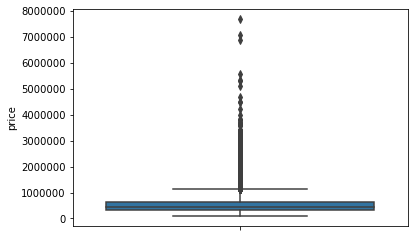

In [68]:
sns.boxplot(data['price'], orient='v')

In [69]:
data['price'].describe()

count    2.159700e+04
mean     5.402966e+05
std      3.673681e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

All the outliers are on the higher end, skewing the data. Since the 75% bound is close to the median price in 2020, I'm going to redefine the data to 2 standard deviations above and below that.

In [70]:
y_range = ((data['price'].std()*2) - 645000), (645000 + (data['price'].std()*2))
y_range

(89736.280202789, 1379736.280202789)

In [71]:
new_data = data[data['price'].between(y_range[0], y_range[1])]

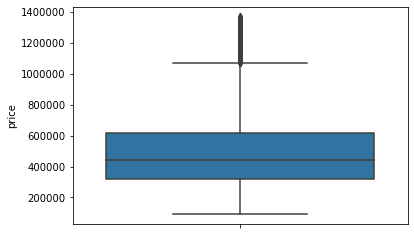

In [72]:
sns.boxplot(new_data['price'], orient='v')

Even with that, there are still a lot of outliers so I am going to filter out the outliers outside the upper bound of the boxplot.

In [73]:
new_data = new_data.loc[new_data['price'] <= 1150000]

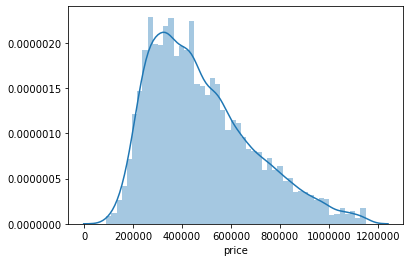

In [74]:
sns.distplot(new_data['price'])

In [75]:
new_data['price'].describe()

count    2.050200e+04
mean     4.793161e+05
std      2.110772e+05
min      8.995000e+04
25%      3.150000e+05
50%      4.390000e+05
75%      6.050000e+05
max      1.150000e+06
Name: price, dtype: float64

In [76]:
(data.shape[0] - new_data.shape[0])/ data.shape[0]

0.050701486317544106

That filtering only eliminated 5% of the original data so there is still a significant amount to work with. The data now falls within a realistic range for my potential buyer, but the mean is a bit lower than the median market price I referenced earlier. Looking at the distribution of the data again, it's really skewed toward the lower end so it's a limitation of the dataset I have.

## Data Preparation

### Data Cleaning
Previewing the data I can see there are some null values I'll have to deal with. These are coming from year renovated, view, and waterfront. It also looks like sqft_basement is an object not at integer. On a closer look, many of the rows contain a '?'. I'm going to fill nulls and examine the data more closely.

For Waterfront and View:

 - There are only 146 houses that are coded as waterfront. I don't want to drop nulls because there are over 2K, so I am going to fill the null values with 0 since it won't affect the distribution much.
 - The view column has 63 null values. This column describes how many times a house has been viewed (not the views from the house), which I don't see as being really important as a feature because there are a lot of reasons it could/could not have been viewed a given number of times. I am going to fill these nulls with a 0 assuming they were not available to view.


In [77]:
new_data['waterfront'].fillna(0.0, inplace=True)
new_data['view'].fillna(0.0, inplace=True)

For year renovated, I am going to assume the nulls represent houses that were not renovated. I'm going to fill the nulls with 0, but also make a binary indicator column that just tells me whether the house was or was not renovated instead of what year. I'll keep both columns for now.

In [78]:
new_data['yr_renovated'].fillna(0.0, inplace=True)

#new column  
new_data['is_renovated'] = 0

# loop through the data and input a 1 where the house was renovated
for row in new_data.index:
    if new_data['yr_renovated'][row] != 0.0:
        new_data['is_renovated'][row] = 1

Lastly for squarefoot basement, I am going to replace all the '?' symbols with 0 to make this column readable, assuming these houses do not have basements.

In [79]:
new_data['sqft_basement'] = new_data['sqft_basement'].map(lambda x: x.replace("?", "0"))
new_data['sqft_basement'] = pd.to_numeric(new_data['sqft_basement'], downcast='integer')

After running a .describe and examining some columns, I see one outlier I want to remove because it looks incorrect - a house that has 33 bedrooms and 1.75 bath that costs only $640k.

In [80]:
new_data[new_data.bedrooms == new_data.bedrooms.max()]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,is_renovated
15856,2402100895,6/25/2014,640000.0,33,1.75,1620,6000,1.0,0.0,0.0,...,1040,580,1947,0.0,98103,47.6878,-122.331,1330,4700,0


In [81]:
new_data = new_data.drop([15856], axis=0)

### Preprocessing

Now I am going to examine the data to see how it will need to be processed to fit to a model. 

First I'm going to separate my continuous from categorical columns so I can treat each type appropriately. I am excluding ID, date and the sqft 15 columns for now. The dates are all from the same 2 years so there isn't a diverse amount of data - it basically just tells me that all these houses were sold. The neighboring house info is not relevant since my stakeholders are working on a new development for which they'll design neighboring houses.

I'm separating out latitude and longitude since they are technically continuous but can't be treated the same way as other continuous variables.

In [82]:
cat_cols= ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'condition', 'grade', 'yr_built', 'view', 'is_renovated', 'zipcode']
con_cols = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']
geo_cols= ['lat', 'long']
y = new_data['price']
X_cols = new_data[cat_cols + con_cols + geo_cols]

Then I'm going to run a few visual techniques to take a look at my data and see what features I may need to address for modeling. First, looking at the distributions.

In [83]:
# sns.pairplot(data[con_cols])
# sns.pairplot(data[cat_cols])

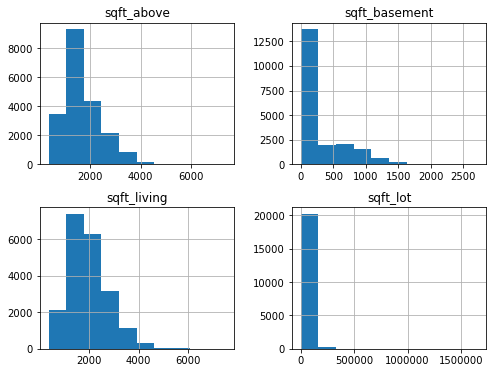

In [84]:
#running a histogram to examine the distribution of continuous columns
fig = plt.figure(figsize = (8,6))
ax = fig.gca()
new_data[con_cols].hist(ax = ax);

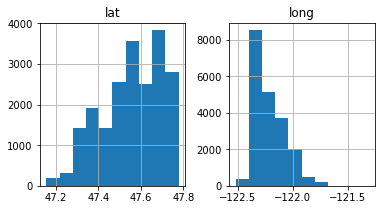

In [85]:
#running a histogram to examine the distribution of lat & long columns
fig = plt.figure(figsize = (6,3))
ax = fig.gca()
new_data[geo_cols].hist(ax = ax);

None of my continuous variables look normally distributed so I'm going to note that I'll probably need to go back and normalize them.

Now I want to look for potential multicollinearity. I'll use a heat map of all the columns.

(16, 0)

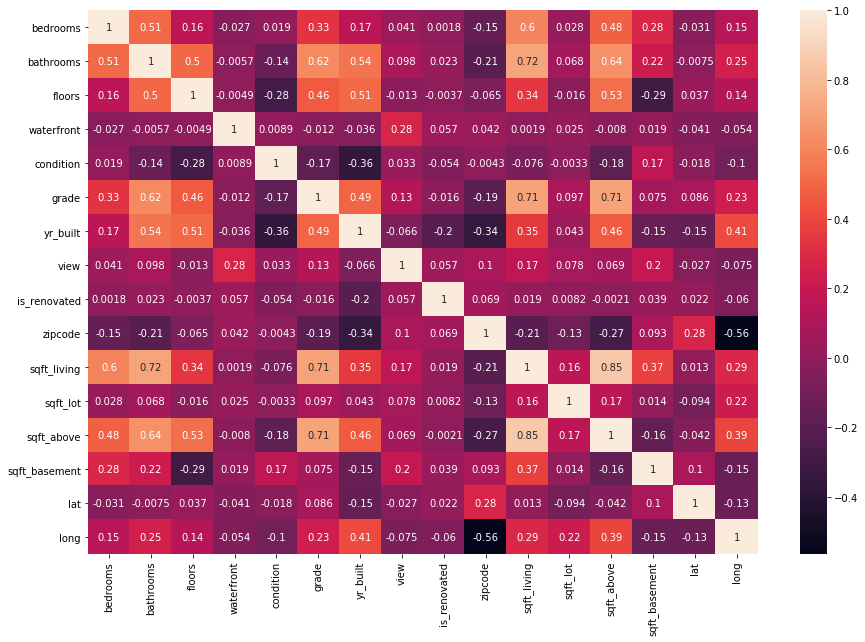

In [86]:
plt.figure(figsize = (15,10))
ax = sns.heatmap(new_data[cat_cols + con_cols + geo_cols].corr(), annot=True)
ax.set_ylim(16,0)

I can see that some features have high correlations (above 0.75): Bathrooms + sqft, grade & sqft, sqft above and sqft living. I'll keep this in mind for feature engineering, but first I'm going to run a 'baseline' model.

## Modeling

### First 'Substandard' Model & Evaluation

Before I go into feature selection, I'll quickly run a basic model. Since CRISP-DM is an iterative process, I'll start with this and then circle back as many times as necessary to get the results I'm looking for.

I'm going to use a pretty standard train-test split of 70/30, scale my data, and fit it to a model. 

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X_cols, y, test_size=0.3, random_state=46)

#using a standard scaler so I can interpret coefficients
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [88]:
#fitting my model
linreg = LinearRegression()
model = linreg.fit(X_train_scaled, y_train)

#obtaining predicted values for both train and test data
y_hat_train = linreg.predict(X_train_scaled)
y_hat_test = linreg.predict(X_test_scaled)

In [89]:
#calculating residuals for analysis
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [90]:
# print(f'Train Mean Squarred Error: {mean_squared_error(y_train, y_hat_train)}')
# print(f'Test Mean Squarred Error: {mean_squared_error(y_test, y_hat_test)}')
print(f'Train Root Mean Squarred Error: {np.sqrt(mean_squared_error(y_train, y_hat_train))}')
print(f'Test Root Mean Squarred Error: {np.sqrt(mean_squared_error(y_test, y_hat_test))}')
print(f'Train R2: {r2_score(y_train, y_hat_train)}')
print(f'Test R2: {r2_score(y_test, y_hat_test)}')

Train Root Mean Squarred Error: 117178.70906607788
Test Root Mean Squarred Error: 116922.6254161257
Train R2: 0.6902425702747903
Test R2: 0.696713144755978


So, my R2 score actually isn't terrible, and the train & test are close to each other. 

However, there is a lot of error, and I'd like to improve the accuracy of the model. 

Circling back to the Data Preparation stage, I want to make some transformations on columns that do not fit the assumptions for linear regression. I'll start with transforming the continuous variables, since all look non-normal, and then address the multicollinearity.

Before I move on, I want to take a quick look at the coefficients so I don't remove anything that may be important.

In [91]:
#getting my coefficients and formmating them into a readable, sorted dataframe

coefficients = linreg.coef_
# coefficients = abs(coefficients)
coef_dict = dict(list(zip(X_cols.columns, coefficients)))
coef_df = pd.DataFrame.from_dict(coef_dict, orient='index')
coef_df.sort_values(by=[0], ascending=False)

,0
grade,726902.833200
sqft_living,462051.245070
lat,340076.430478
sqft_above,222098.164224
sqft_lot,167895.052665
bathrooms,153666.562722
waterfront,149284.104849
view,139425.182528
condition,97468.939994
floors,65575.123819


At a first glance, all the features show influence over the target but some much more so than others. I may remove some that are redundant (i.e. there are many different indicators of the size of the house). I know zipcode is not beaing read correctly so I will work on a better indicator of location.

## Back to Data Preparation

My next step is to normalize continuous columns. Since this is mainly the sqft columns, I'm going to log transform them, but also eliminate some due to multicollinearity.

I saw in my heatmap that these columns had high correlations with eachother, and looking at their definitions this makes sense:

* **sqft_living** -  footage of the home
* **sqft_lot** -  footage of the lot
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement

Sqft_living has high correlation with sqft_above, because sqft_living = sqft_above + sqft_basement, and not all houses have basements. 

Since sqft_living had one of the highest coefficients in my baseline model, I'm not going to use sqft above so that we are factoring in the total sqft of the house, and the total sqft of the lot. I am going to remove the sqft_basement column and add a binary indicator, has_basement, since the total area will be captured in sqft_living.

In [92]:
new_data['sqft_living_log'] = np.log1p(data["sqft_living"])
new_data['sqft_lot_log'] = np.log1p(data["sqft_lot"])

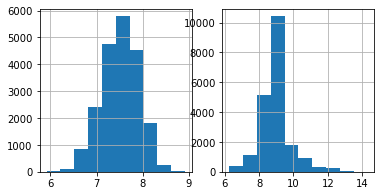

In [93]:
plt.figure(figsize=(6, 3))
ax1 = plt.subplot(1, 2, 1)
new_data['sqft_living_log'].hist();

ax2 = plt.subplot(1,2,2)
new_data['sqft_lot_log'].hist();


In [94]:
#new column  
new_data['has_basement'] = 0

# loop through the data and input a 1 where there is a basement
for row in new_data.index:
    if new_data['sqft_basement'][row] != 0:
        new_data['has_basement'][row] = 1

In [95]:
new_X = pd.concat([new_data[geo_cols], new_data['sqft_living_log'], new_data['sqft_lot_log'], new_data['has_basement'], new_data[cat_cols]], axis=1)

In [96]:
#checking high multicollinearity again
new_X.corr() > 0.75

,lat,long,sqft_living_log,sqft_lot_log,has_basement,bedrooms,bathrooms,floors,waterfront,condition,grade,yr_built,view,is_renovated,zipcode
lat,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
long,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
sqft_living_log,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
sqft_lot_log,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
has_basement,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
bedrooms,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
bathrooms,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
floors,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
waterfront,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
condition,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False


My continuous variables look more normal and I've gotten rid of high multicollinearity. I'm going to run the model again to see if it's improved. 

### Second Model

In [98]:
X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size=0.3, random_state=46)
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled_2 = scaler.transform(X_train)
X_test_scaled_2 = scaler.transform(X_test)
model2 = linreg.fit(X_train_scaled_2, y_train)

In [99]:
y_hat_train = linreg.predict(X_train_scaled_2)
y_hat_test = linreg.predict(X_test_scaled_2)

In [100]:
print(f'Train Root Mean Squarred Error: {np.sqrt(mean_squared_error(y_train, y_hat_train))}')
print(f'Test Root Mean Squarred Error: {np.sqrt(mean_squared_error(y_test, y_hat_test))}')
print(f'Train R2: {r2_score(y_train, y_hat_train)}')
print(f'Test R2: {r2_score(y_test, y_hat_test)}')

Train Root Mean Squarred Error: 118948.41193415852
Test Root Mean Squarred Error: 118888.82433603807
Train R2: 0.6808156346712592
Test R2: 0.6864270904634585


So my first 'real' model doesn't seem significantly better than the baseline - the r squared decreased very slightly and the RMSE increased very slightly. 

I want to know more about which features to keep in my model since it seems slightly overfit, maybe due to the fact that I have 15 variable columns. Before I work through categorical variables, so I am going to use Recursive Feature Elimination (RFE) from Scikit learn, which will help automate feature selection by training the data on each feature and analyzing its importance. 

To start off I'm going to tell it to select 12 of my 15 current features.

In [101]:
from sklearn.feature_selection import RFE
selector = RFE(linreg, n_features_to_select=12)
selector = selector.fit(new_X, new_data['price'])
dict(zip(new_X.columns, selector.support_ ))

{'lat': True,
 'long': True,
 'sqft_living_log': True,
 'sqft_lot_log': False,
 'has_basement': False,
 'bedrooms': True,
 'bathrooms': True,
 'floors': True,
 'waterfront': True,
 'condition': True,
 'grade': True,
 'yr_built': True,
 'view': True,
 'is_renovated': True,
 'zipcode': False}

In [35]:
coef_dict = dict(list(zip(new_X.columns, coefficients)))
coef_df = pd.DataFrame.from_dict(coef_dict, orient='index')
coef_df.sort_values(by=[0], ascending=False)

,0
bedrooms,734690.127271
grade,402699.748039
zipcode,346030.989070
view,279119.756866
yr_built,227123.079082
floors,153072.848337
long,147687.897666
sqft_lot_log,120792.745370
has_basement,104610.239058
is_renovated,78269.810338


Since I haven't addressed categorical variables I'm going to examine the location-related ones and then look at year built. 

Zipcode and lat/long are both indicators of location so I want to examine these a little closer and see if I can make them more useful. So far the coeficients and the RFE suggest that lat/long data has more potential usefulness than zipcode, but it's probably becuase the model is reading zipcode incorrectly. To get an idea of what the locations of these houses look like, I'm going to plot them.

In [102]:
import plotly.graph_objects as go

#create a scatter geo plot with lat/long coordinates from my dataframe

fig = go.Figure(data=go.Scattergeo(lon = new_data['long'], lat = new_data['lat'], mode = 'markers'))

fig.update_layout(
        title = 'Kings County Houses',
        geo = dict(
            scope='usa',
            projection_type='albers usa',
            showland = True))

# defining where to zoom in by taking the median of both coordinate columns making that the center
lat_foc = new_data['lat'].median()
lon_foc = new_data['long'].median()
fig.update_layout(
        geo = dict(
            projection_scale=25, #how much to zoom in 
            center=dict(lat=lat_foc, lon=lon_foc)))

fig.show()
plt.savefig('Images/house_map_scatter')

<Figure size 432x288 with 0 Axes>

It's clear from this map that there are some outlier houses that are far from the center of town. Assuming distance from the center is a factor in price, I'm going to create a column to reflect that. I'm going to use the mpu library which has a haversine distance feature that can calculate the distance between two sets of lat/long coordinates in kilometers.

In [103]:
import mpu

#creating a new column that contains the lat & long of each row as a tupule
new_data['lat_long'] = list(zip(new_data.lat, new_data.long))

# official coordinates of seattle
seattle_center = (47.6062, 122.3321)

#creating another column that will calculate the distance between each house and the center of the city

new_data['dist_from_city'] = 0

for row in new_data.index:
    house_loc = new_data['lat_long']
    new_data['dist_from_city'][row] = mpu.haversine_distance(seattle_center, house_loc[row])

Since the distribution of the distance data is non-normal, I'm going to normalize and add to my continuous variables. I'll remove the original lat & long columns, as well as zipcode since I am using distance from city center as my location variable. 

In [104]:
new_X['dist_log'] = np.log1p(new_data['dist_from_city'])

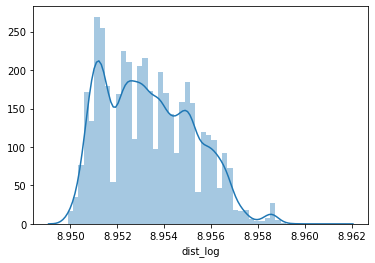

In [105]:
sns.distplot(new_X['dist_log'])

In [106]:
new_X = new_X.drop(['zipcode'], axis=1)

In [115]:
new_X = new_X.drop(['lat'], axis=1)

In [116]:
new_X = new_X.drop(['long'], axis=1)

Since my model got worse, I am going to take a look at residuals. 

In [117]:
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

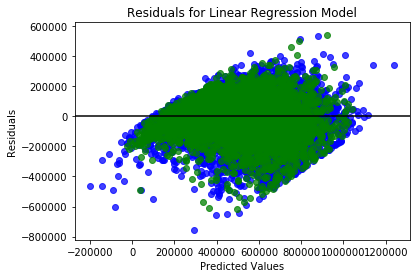

In [118]:
plt.scatter(y_hat_train, train_residuals, color='b', alpha=.75)
plt.scatter(y_hat_test, test_residuals, color='g', alpha=.75)

plt.axhline(y=0, color='black')

plt.title('Residuals for Linear Regression Model')
plt.ylabel('Residuals')
plt.xlabel('Predicted Values')
plt.show()

My training data is under-predicting prices and I am seeing house prices around zero.

### Third Model

In [119]:
X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size=0.3, random_state=46)
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled_3 = scaler.transform(X_train)
X_test_scaled_3 = scaler.transform(X_test)
model3 = linreg.fit(X_train_scaled_3, y_train)

In [120]:
y_hat_train = linreg.predict(X_train_scaled_3)
y_hat_test = linreg.predict(X_test_scaled_3)

In [121]:
print(f'Train Root Mean Squarred Error: {np.sqrt(mean_squared_error(y_train, y_hat_train))}')
print(f'Test Root Mean Squarred Error: {np.sqrt(mean_squared_error(y_test, y_hat_test))}')
print(f'Train R2: {r2_score(y_train, y_hat_train)}')
print(f'Test R2: {r2_score(y_test, y_hat_test)}')

Train Root Mean Squarred Error: 124442.72990877245
Test Root Mean Squarred Error: 125521.2527196968
Train R2: 0.6506478880548066
Test R2: 0.6504647334643876


In [122]:
coefficients = linreg.coef_
# coefficients = abs(coefficients)
coef_dict = dict(list(zip(new_X.columns, coefficients)))
coef_df = pd.DataFrame.from_dict(coef_dict, orient='index')
coef_df.sort_values(by=[0], ascending=False)

,0
grade,802578.067371
sqft_living_log,553447.989491
bathrooms,178559.952533
view,116403.275628
waterfront,111946.688659
condition,90804.383103
sqft_lot_log,87260.984393
floors,60836.059416
is_renovated,25442.539250
has_basement,-12101.403851


In [123]:
new_data['yrs_since_built'] = 0

for row in new_data.index:
    new_data['yrs_since_built'] = 2020 - (new_data['yr_built'])

In [124]:
new_X = pd.concat([new_X, new_data[['yrs_since_built']]], axis=1)

In [129]:
X_third = new_X[['sqft_living_log', 'sqft_lot_log', 'bedrooms', 'bathrooms', 'floors', 'condition', 'grade',
       'yr_built', 'view', 'dist_log', 'yrs_since_built']]

### Fourth Model

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X_third, y, test_size=0.25, random_state=20)
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled_4 = scaler.transform(X_train)
X_test_scaled_4 = scaler.transform(X_test)
model3 = linreg.fit(X_train_scaled_4, y_train)

In [131]:
y_hat_train = linreg.predict(X_train_scaled_4)
y_hat_test = linreg.predict(X_test_scaled_4)

In [132]:
print(f'Train Root Mean Squarred Error: {np.sqrt(mean_squared_error(y_train, y_hat_train))}')
print(f'Test Root Mean Squarred Error: {np.sqrt(mean_squared_error(y_test, y_hat_test))}')
print(f'Train R2: {r2_score(y_train, y_hat_train)}')
print(f'Test R2: {r2_score(y_test, y_hat_test)}')

Train Root Mean Squarred Error: 125126.2240204795
Test Root Mean Squarred Error: 124770.01028045677
Train R2: 0.6475073614187024
Test R2: 0.653727004301045


In [53]:
coefficients = linreg.coef_
coefficients = abs(coefficients)
coef_dict = dict(list(zip(new_X.columns, coefficients)))
coef_df = pd.DataFrame.from_dict(coef_dict, orient='index')
coef_df.sort_values(by=[0], ascending=False)

,0
floors,4.465150e+17
yr_built,4.465150e+17
bathrooms,8.029859e+05
lat,5.514153e+05
grade,4.178214e+05
sqft_lot_log,1.583615e+05
sqft_living_log,1.564591e+05
waterfront,1.346836e+05
long,1.000337e+05
bedrooms,9.838680e+04


In [54]:
len(new_X.columns)

16

In [55]:
selector = RFE(linreg, n_features_to_select=10)
selector = selector.fit(new_X, new_data['price'])
dict(zip(new_X.columns, selector.support_ ))

{'lat': True,
 'long': True,
 'sqft_living_log': True,
 'sqft_lot_log': False,
 'has_basement': False,
 'bedrooms': False,
 'bathrooms': True,
 'floors': False,
 'waterfront': True,
 'condition': False,
 'grade': True,
 'yr_built': True,
 'view': True,
 'is_renovated': False,
 'dist_log': True,
 'yrs_since_built': True}

## Evaluation

## Conclusions

Provide your conclusions about the work you've done, including any limitations or next steps.

Questions to consider:

- What would you recommend the business do as a result of this work?
- What are some reasons why your analysis might not fully solve the business problem?
- What else could you do in the future to improve this project (future work)?
